# User input

You are free to change these two parameters accordingly:

In [ ]:
n = 3 # number of time series selected
dataset = '/content/drive/My Drive/Colab Notebooks/Project3/nasdaq2007_17.csv' # path to the dataset

# Dataset loading and editing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import pandas as pd
import numpy as np

print('Python version ' + sys.version)
print("---------------------------------------")

df = pd.read_csv(dataset, delimiter='\t', header=None)

df.rename(columns = {0:'id'}, inplace=True) #rename the first column to "id"
print(df.info())

Mounted at /content/drive
Python version 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Columns: 3651 entries, id to 3650
dtypes: float64(3650), object(1)
memory usage: 10.0+ MB
None


Set seed for reproductability:

In [ ]:
import os
import random
import tensorflow

def reproducibleResults(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tensorflow.random.set_seed(seed)
    np.random.seed(seed)

reproducibleResults(12345)

# Single time series models

## Model creation and training

Choose n time series randomly from the dataset:

In [ ]:
df.sample(frac=1, random_state=1).reset_index(drop=True) # shuffle the dataframe

chosen_series = df.sample(n=n, random_state=1)
print(chosen_series)

# get only the numeric values
column_names = chosen_series.columns.values.tolist()
values = chosen_series.iloc[:, column_names[1:]].values

       id       1       2       3       4  ...   3646   3647   3648   3649   3650
127   etn  16.262  15.916  15.822  15.630  ...  78.31  78.67  79.05  77.86  77.92
111   dvn  22.280  22.014  22.050  23.281  ...  40.86  41.26  40.26  40.81  40.41
352  xlnx  24.126  22.953  22.937  22.888  ...  74.50  73.91  73.62  70.76  71.87

[3 rows x 3651 columns]


Create the train and validation sets while scaling each time series seperately:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

window = 50
slice_index = int(len(values[0])*0.8)

X_train = []
y_train = []
X_valid = []
y_valid = []
scalers = []

for series in values:
  curr_scaler = MinMaxScaler(feature_range = (0, 1))
  scalers.append(curr_scaler)

  Xt_values = []
  yt_values = []
  known_series = series[:slice_index]
  known_series = known_series.reshape(-1, 1)
  known_series = curr_scaler.fit_transform(known_series)
  for i in range(window, slice_index):
    Xt_values.append(known_series[i-window : i])
    yt_values.append(known_series[i])
  X_train.append(Xt_values)
  y_train.append(yt_values)

  Xv_values = []
  yv_values = []
  inputs = series[slice_index-window:]
  inputs = inputs.reshape(-1, 1)
  inputs = curr_scaler.transform(inputs)
  for i in range(window, len(inputs)):
    Xv_values.append(inputs[i-window: i])
    yv_values.append(inputs[i])
  X_valid.append(Xv_values)
  y_valid.append(yv_values)

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
print(X_valid.shape, y_valid.shape)

(3, 2870, 50, 1) (3, 2870, 1)
(3, 730, 50, 1) (3, 730, 1)


Create and train the models (usually this step takes ~1min per model):

In [ ]:
import keras

trained_models = []

for i in range(n):
  model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, input_shape=(window, 1)),
  keras.layers.Dropout(0.2),
  keras.layers.LSTM(100),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(1)
  ])

  model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  history = model.fit(X_train[i], y_train[i], epochs = 10, batch_size=128, validation_data=(X_valid[i], y_valid[i]))
  trained_models.append((model, history))

Epoch 1/10
23/23 [==============================] - 10s 281ms/step - loss: 0.0249 - val_loss: 0.0014
Epoch 2/10
23/23 [==============================] - 6s 242ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 3/10
23/23 [==============================] - 6s 241ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 4/10
23/23 [==============================] - 6s 241ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 5/10
23/23 [==============================] - 6s 241ms/step - loss: 0.0016 - val_loss: 9.7221e-04
Epoch 6/10
23/23 [==============================] - 6s 241ms/step - loss: 0.0015 - val_loss: 9.3833e-04
Epoch 7/10
23/23 [==============================] - 6s 240ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/10
23/23 [==============================] - 5s 239ms/step - loss: 0.0013 - val_loss: 9.4345e-04
Epoch 9/10
23/23 [==============================] - 5s 240ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/10
23/23 [==============================] - 6s 242ms/step - loss: 0.0012 - val

Use the models to make predictions:

In [ ]:
predictions = []
realities = []
for i in range(len(trained_models)):
  predicted_stock = trained_models[i][0].predict(X_valid[i])
  predicted_stock = scalers[i].inverse_transform(predicted_stock)
  predicted_stock = np.squeeze(predicted_stock)
  real_stock = values[i][slice_index:]
  predictions.append(predicted_stock)
  realities.append(real_stock)

## Choosing which model/series to plot 

To choose for which of the trained models to plot, please change the variable *model_num* bellow accordingly (value must be an integer in [1, n], where n is the number of models given at the beginning):  

In [ ]:
model_num = 3

### Plotting predictions

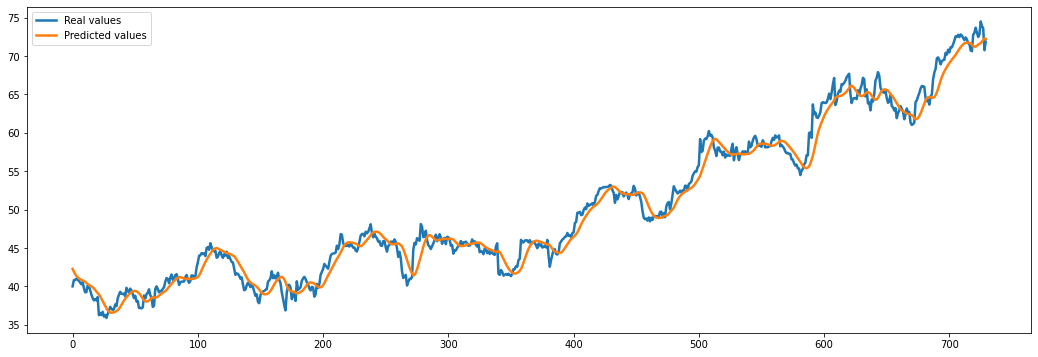

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18,6))
plt.plot(realities[model_num-1], label="Real values", linewidth=2)
plt.plot(predictions[model_num-1], label="Predicted values", linewidth=2)
plt.legend()
plt.show()

### Plotting training and validation MSE

This step is used to check if the model is overfitting:

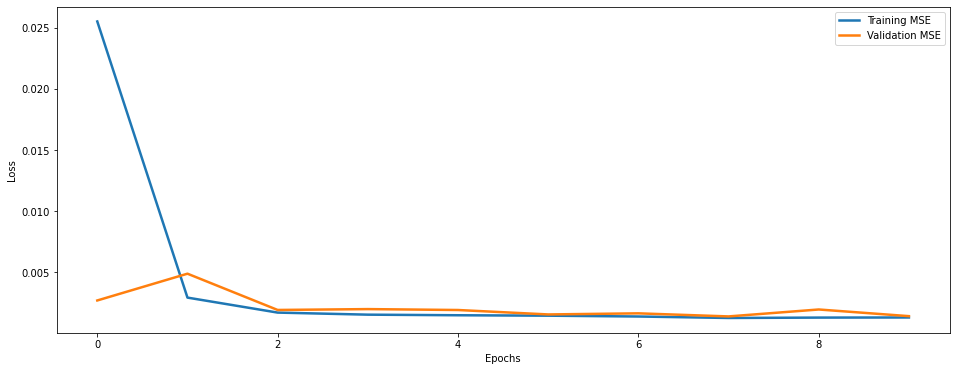

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss_values = trained_models[model_num-1][1].history['loss']
val_loss_values = trained_models[model_num-1][1].history['val_loss']
epochs = range(1, len(train_loss_values)+1)

plt.figure(figsize=(16,6))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss_values, label="Training MSE", linewidth=2.5)
plt.plot(val_loss_values, label="Validation MSE", linewidth=2.5)
plt.legend()
plt.show()

# Multi-time series model

## Choosing model directory

In [ ]:
dir = '/content/drive/My Drive/Colab Notebooks/Project3/Saves/' # the directory to which the model will be save or from which it will be loaded
load = True # change to False if you want to train a new model
model_name = 'final_model.h5' # file name of saved model (file must be of type .h5)

## Model creation and training (if needed)

In [ ]:
df.sample(frac=1, random_state=1).reset_index(drop=True) # shuffle the dataframe

# get only the numeric values
column_names = df.columns.values.tolist()
cols_to_scale = column_names[1:]
values = df.iloc[:, column_names[1:]].values

Create the train and validation sets while scaling each time series seperately:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

window = 50
lag = 4
slice_index = int(len(values[0])*0.8)

X_train = []
y_train = []
X_valid = []
y_valid = []

scaler = MinMaxScaler(feature_range = (0, 1))
for series in values:
  known_series = series[:slice_index]
  known_series = known_series.reshape(-1, 1)
  known_series = scaler.fit_transform(known_series)
  for i in range(window, slice_index, lag):
    X_train.append(known_series[i-window : i])
    y_train.append(known_series[i])
    
  inputs = series[slice_index-window:]
  inputs = inputs.reshape(-1, 1)
  inputs = scaler.transform(inputs)
  for i in range(window, len(inputs)):
    X_valid.append(inputs[i-window: i])
    y_valid.append(inputs[i])

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
print(X_valid.shape, y_valid.shape)

(257762, 50, 1) (257762, 1)
(262070, 50, 1) (262070, 1)


Create and train the model (this step will take some time):

In [ ]:
import keras
import time

if load == False:
  start = time.time()
  model = keras.models.Sequential([
  keras.layers.LSTM(50, return_sequences=True, input_shape=(window, 1)),
  keras.layers.Dropout(0.3),
  keras.layers.LSTM(50),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(1)
  ])

  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  history = model.fit(X_train, y_train, epochs = 20, batch_size=2048, validation_data=(X_valid, y_valid))
  end = time.time()
  print("Time needed: ", (end-start)/60)

Epoch 1/20
126/126 [==============================] - 187s 1s/step - loss: 0.0093 - val_loss: 0.0097
Epoch 2/20
126/126 [==============================] - 180s 1s/step - loss: 0.0032 - val_loss: 0.0094
Epoch 3/20
126/126 [==============================] - 181s 1s/step - loss: 0.0027 - val_loss: 0.0082
Epoch 4/20
126/126 [==============================] - 179s 1s/step - loss: 0.0024 - val_loss: 0.0059
Epoch 5/20
126/126 [==============================] - 178s 1s/step - loss: 0.0022 - val_loss: 0.0052
Epoch 6/20
126/126 [==============================] - 179s 1s/step - loss: 0.0020 - val_loss: 0.0048
Epoch 7/20
126/126 [==============================] - 180s 1s/step - loss: 0.0019 - val_loss: 0.0040
Epoch 8/20
126/126 [==============================] - 182s 1s/step - loss: 0.0018 - val_loss: 0.0032
Epoch 9/20
126/126 [==============================] - 180s 1s/step - loss: 0.0017 - val_loss: 0.0034
Epoch 10/20
126/126 [==============================] - 180s 1s/step - loss: 0.0016 - val_lo

## Plotting training and validation MSE

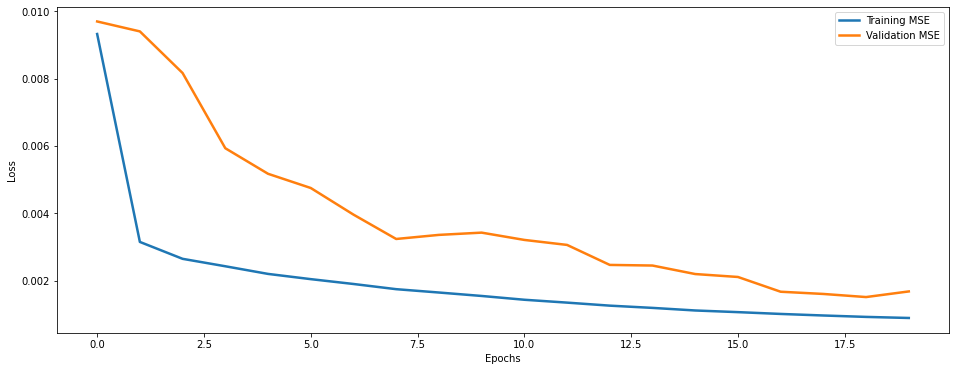

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

if load == False :
  train_loss_values = history.history['loss']
  val_loss_values = history.history['val_loss']
  epochs = range(1, len(train_loss_values)+1)

  plt.figure(figsize=(16,6))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(train_loss_values, label="Training MSE", linewidth=2.5)
  plt.plot(val_loss_values, label="Validation MSE", linewidth=2.5)
  plt.legend()
  plt.show()

Save the model if needed:

In [ ]:
if load == False:
  !pip install h5py pyyaml
  full_path = dir + model_name
  model.save(full_path)

Load the model if needed:

In [ ]:
if load == True:
  full_path = dir + model_name
  model = keras.models.load_model(full_path)
  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


## Choosing which series to plot

We are gonna make predictions for all the time series and so you can choose to plot any one of them by changing the *series_num* variable bellow (value must be an integer in [1, n], where n is the number of series in the dataset):

In [ ]:
series_num = 351

This step may take some time:

In [ ]:
predictions = model.predict(X_valid)
print(predictions.shape)

(262070, 1)


## Plotting predictions

In [ ]:
pred_length = values.shape[1] - slice_index

predicted_series = []
for i in range(0, len(predictions), pred_length):
  predicted_series.append(predictions[i:i+pred_length])

print(len(predicted_series))

359


In [ ]:
real_series = []
for i in range(0, len(y_valid), pred_length):
  real_series.append(y_valid[i:i+pred_length])

print(len(real_series))

359


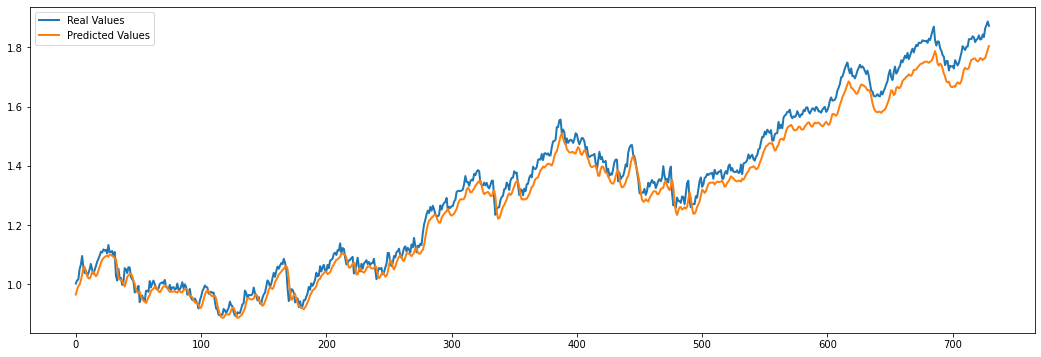

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18,6))
plt.plot(real_series[series_num-1], label="Real Values", linewidth=2)
plt.plot(predicted_series[series_num-1], label="Predicted Values", linewidth=2)
plt.legend()
plt.show()